
# Impact du streaming sur la consommation musicale : concentration vs diversité

Ce notebook explore les Top 100 titres les plus écoutés par décennie (1990s → 2020s), en France et aux USA, avec pour objectif de mettre en lumière comment le streaming a transformé la consommation musicale.

Si les volumes totaux d’écoute ont explosé avec le streaming, le modèle actuel du marché tend à favoriser les gros hits et les artistes dominants, parfois au détriment des artistes émergents, alors même que les auditeurs explorent aujourd’hui une diversité plus grande d’artistes et de genres.

# Objectifs du notebook

1. Préparer et normaliser les données

        Lecture de CSV France/USA, standardisation des colonnes (rank, track_name, artist_name, streams, decade).

2. Quantifier concentration et diversité

        Calcul de la concentration des streams via l’HHI (Herfindahl-Hirschman Index).

        Comparaison de la part cumulée du Top 10 vs longue traîne.

        Distribution des streams par artiste pour chaque décennie.

3. Visualiser l’évolution des habitudes d’écoute

        Courbes des streams totaux par décennie pour observer l’impact du streaming.

        Graphiques illustrant le paradoxe actuel : domination des gros hits malgré une consommation plus diversifiée par les auditeurs.

4. Analyser les limites du modèle actuel

        Montrer que les stratégies centrées sur les hits dominants ne reflètent plus complètement les comportements d’écoute.

        Identifier des pistes pour mieux comprendre et accompagner la diversité émergente sur les plateformes de streaming.

In [41]:

# Imports
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Définition des répertoires ---
BASE_DIR = Path("C:/Users/pc/Documents/File_music_project")
DATA_DIR = BASE_DIR / "data"
EXPORT_DIR = BASE_DIR / "exports"

# Création automatique des répertoires si besoin
DATA_DIR.mkdir(parents=True, exist_ok=True)
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# --- Configuration pandas ---
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 150)

print("DATA_DIR   =", DATA_DIR)
print("EXPORT_DIR =", EXPORT_DIR)


DATA_DIR   = C:\Users\pc\Documents\File_music_project\data
EXPORT_DIR = C:\Users\pc\Documents\File_music_project\exports


# Initialisation de l’environnement

Avant d’analyser les tendances de consommation musicale, cette section prépare le cadre technique du projet.
L’objectif est d’organiser proprement les répertoires et d’assurer un environnement stable pour charger, manipuler et visualiser les données.

# Ce bloc de code :

- # importe les bibliothèques principales :
        pandas et numpy pour la manipulation de données, matplotlib pour la visualisation, et pathlib pour la gestion des chemins.
        Les avertissements mineurs sont désactivés afin d’alléger la lecture du notebook.

- # structure les dossiers du projet :
        BASE_DIR définit le dossier principal du projet, tandis que DATA_DIR et EXPORT_DIR contiennent respectivement les données brutes et les résultats d’analyse (exports, graphiques, résumés).

        crée automatiquement les répertoires manquants, garantissant que le code puisse tourner sans erreur, même sur un nouvel environnement.

        configure l’affichage de pandas pour un rendu plus lisible des tableaux dans le notebook.

Cette étape ne produit pas encore d’analyse, mais elle constitue la colonne vertébrale technique du projet : elle prépare le terrain pour explorer comment le passage au streaming a transformé la structure de l’industrie musicale.

In [42]:

# === RENSEIGNER ICI ===
# Option A : un fichier global avec une colonne 'country'
PATH_ALL = '' 

# Option B : deux fichiers séparés (FR et US). Laisser PATH_ALL vide si vous utilisez cette option.
PATH_FR = 'C:Users/pc/Documents/File_music_project/top100_decade_FR_all.csv'  
PATH_US = 'C:Users/pc/Documents/File_music_project/top100_decade_USA_all.csv'  

# Pays considérés
COUNTRY_ALIASES = {
    'fr': 'France', 'FR': 'France', 'France': 'France',
    'us': 'USA', 'US': 'USA', 'United States': 'USA', 'U.S.': 'USA', 'USA': 'USA'
}

# Mapping de colonnes possibles -> colonnes cibles
COLUMN_MAP_CANDIDATES = [
    {
        'track_id': ['track_id', 'song_id', 'id', 'spotify_track_id', 'mb_track_id'],
        'track_name': ['track_name', 'title', 'song', 'name'],
        'artist_name': ['artist_name', 'artist', 'primary_artist', 'artists'],
        'date': ['date', 'day', 'week', 'month', 'year'],
        'streams': ['streams', 'plays', 'listens', 'units', 'units_sold', 'count'],
        'country': ['country', 'market', 'territory', 'nation', 'country_code'],
        'label': ['label', 'record_label', 'imprint', 'company']
    }
]
from datetime import datetime

START_YEAR = 1990
CURRENT_YEAR = datetime.now().year

print('Chemins: PATH_FR=', PATH_FR, '| PATH_US=', PATH_US)


Chemins: PATH_FR= C:Users/pc/Documents/File_music_project/top100_decade_FR_all.csv | PATH_US= C:Users/pc/Documents/File_music_project/top100_decade_USA_all.csv


# Définition des chemins et paramètres de chargement des données

Cette section sert à définir les sources de données et à rendre le notebook flexible, quel que soit le format ou la provenance des fichiers utilisés.
Elle agit comme un point de configuration global pour le reste du projet.

 # Contenu et rôle des éléments :

- # PATH_ALL / PATH_FR / PATH_US :
Deux options sont prévues selon la manière dont les données sont organisées.

        Option A : un seul fichier contenant une colonne country (utile si les données FR et US sont fusionnées).

        Option B : deux fichiers séparés, un pour la France et un pour les États-Unis (le cas utilisé ici).

- # COUNTRY_ALIASES :
        Dictionnaire de correspondance pour harmoniser les noms de pays, quelle que soit la façon dont ils apparaissent dans les données d’origine (FR, France, U.S., etc.).
        Cela simplifie les filtres et les regroupements par pays dans les étapes suivantes.

- # COLUMN_MAP_CANDIDATES :
        Liste de correspondances entre différents noms possibles de colonnes et les noms standards attendus par le notebook (track_name, artist_name, streams, etc.).
        Ce système permet de charger des jeux de données provenant de sources variées (Billboard, Spotify, SNEP…) sans avoir à renommer manuellement les colonnes.

- # START_YEAR et CURRENT_YEAR :
        Ces variables définissent la période d’analyse (ici de 1990 à aujourd’hui), utilisée plus tard pour filtrer ou regrouper les données par décennie.

Ce bloc agit comme un centre de contrôle du chargement des données.
Il garantit que le notebook puisse fonctionner avec différentes structures de fichiers et reflète la réalité de l’industrie musicale à travers plusieurs décennies — un prérequis essentiel avant d’analyser l’évolution du streaming et de la concentration des écoutes.

In [43]:

def _best_match(colnames, candidates):
    lower = {c.lower(): c for c in colnames}
    for cand in candidates:
        for alias in cand:
            if alias.lower() in lower:
                return lower[alias.lower()]
    return None

def standardize_columns(df, map_candidates=COLUMN_MAP_CANDIDATES):
    dfc = df.copy()
    cols = list(dfc.columns)
    target_cols = {}
    for mapping in map_candidates:
        for target, aliases in mapping.items():
            match = _best_match(cols, aliases)
            if match is not None:
                target_cols[match] = target
    dfc = dfc.rename(columns=target_cols)
    # minimal required after mapping
    required = ['track_name', 'artist_name', 'date', 'streams']
    for r in required:
        if r not in dfc.columns:
            raise ValueError(f"Colonne requise manquante après mapping: '{r}'. Colonnes actuelles: {dfc.columns.tolist()}")
    # Optional: track_id, country, label
    if 'country' not in dfc.columns:
        dfc['country'] = np.nan
    if 'track_id' not in dfc.columns:
        dfc['track_id'] = np.nan
    if 'label' not in dfc.columns:
        dfc['label'] = np.nan
    return dfc

def normalize_values(df):
    df = df.copy()
    # date parsing
    def parse_date(x):
        try:
            return pd.to_datetime(str(x), errors='coerce')
        except:
            return pd.NaT
    df['date'] = df['date'].apply(parse_date)
    # drop rows without date or outside range
    df = df.dropna(subset=['date'])
    df['year'] = df['date'].dt.year.astype(int)
    df = df[(df['year'] >= START_YEAR) & (df['year'] <= CURRENT_YEAR)]
    # country normalization
    def norm_country(x):
        if pd.isna(x): return np.nan
        s = str(x).strip()
        return COUNTRY_ALIASES.get(s, COUNTRY_ALIASES.get(s.upper(), s))
    df['country'] = df['country'].apply(norm_country)
    # streams to numeric
    df['streams'] = pd.to_numeric(df['streams'], errors='coerce')
    df = df.dropna(subset=['streams'])
    # clean strings
    for col in ['track_name','artist_name','label']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()
    # decade bin
    df['decade'] = (df['year'] // 10) * 10
    df['decade'] = df['decade'].astype(int).astype(str) + 's'
    return df

def load_data(path):
    df = pd.read_csv(path)
    df = standardize_columns(df)
    df = normalize_values(df)
    return df

def load_all(PATH_ALL, PATH_FR, PATH_US):
    frames = []
    if PATH_ALL:
        df = load_data(PATH_ALL)
        frames.append(df)
    else:
        if PATH_FR:
            dfr = load_data(PATH_FR)
            dfr['country'] = dfr['country'].fillna('France')
            frames.append(dfr)
        if PATH_US:
            dfu = load_data(PATH_US)
            dfu['country'] = dfu['country'].fillna('USA')
            frames.append(dfu)
    if not frames:
        raise RuntimeError("Aucune donnée chargée. Renseigne PATH_ALL ou PATH_FR/US.")
    data = pd.concat(frames, ignore_index=True)
    # Restreindre aux pays ciblés uniquement (France / USA)
    data = data[data['country'].isin(['France','USA'])]
    return data


# Préparation et normalisation des données — explications

Ce bloc contient des fonctions utilitaires pour standardiser, nettoyer et charger les jeux de données (CSV) avant l’analyse. Elles sont conçues pour rendre le pipeline robuste face à des fichiers venant de sources différentes (colonnes nommées différemment, formats de dates variés, absence de country, etc.).

In [44]:

def top_100_by_decade_country(df, country):
    subset = df[df['country'] == country].copy()
    # Agrégation par (track) sur toute la décennie -> somme des streams
    # On garde aussi un représentant (premier) pour artist_name / label
    group_cols = ['decade', 'track_id', 'track_name', 'artist_name', 'label']
    agg = subset.groupby(group_cols, dropna=False)['streams'].sum().reset_index()
    # Classement par decade
    agg['rank_in_decade'] = agg.groupby('decade')['streams'].rank(method='first', ascending=False)
    top100 = agg[agg['rank_in_decade'] <= 100].copy()
    # tri propre
    top100 = top100.sort_values(['decade', 'rank_in_decade'])
    return top100

def diversity_and_concentration(top_df, entity_col='artist_name'):
    # Diversité = nb d'entités uniques dans le Top 100 par décennie
    diversity = top_df.groupby('decade')[entity_col].nunique().rename('unique_count')
    # HHI (Herfindahl-Hirschman Index) sur parts de streams dans le top par décennie
    parts = (top_df.groupby(['decade', entity_col])['streams'].sum()
             .groupby(level=0).apply(lambda s: (s / s.sum())**2).groupby(level=0).sum())
    hhi = parts.rename('hhi')
    return diversity.reset_index(), hhi.reset_index()

def export_csv(df, name):
    path = EXPORT_DIR / name
    df.to_csv(path, index=False)
    print('Export ->', path)
    return path


# Analyse du Top 100 par décennie et mesure de diversité

Ce bloc introduit trois fonctions essentielles pour extraire, analyser et exporter les classements des morceaux les plus écoutés par décennie et par pays.

- # Ces fonctions permettent de :

Transformer les données brutes en classements significatifs (Top 100 par décennie/pays).

Mesurer l’évolution de la diversité musicale et la concentration du succès sur plusieurs décennies.

Sauvegarder automatiquement les résultats pour réutilisation ou partage.

Ce bloc forme le cœur analytique du projet : il relie les comportements d’écoute (streams) à la structure de la scène musicale au fil du temps.

In [45]:

# 1) Chargement
try:
    data = load_all(PATH_ALL, PATH_FR, PATH_US)
    print('Données chargées :', data.shape, '| Période :', int(data['year'].min()), '→', int(data['year'].max()))
    display(data.head(3))
except Exception as e:
    print('Erreur de chargement:', e)
    data = None


Erreur de chargement: [Errno 2] No such file or directory: 'C:Users/pc/Documents/File_music_project/top100_decade_FR_all.csv'


In [46]:

# 2) Calcul Top 100 FR & USA
if data is not None:
    top_fr = top_100_by_decade_country(data, 'France')
    top_us = top_100_by_decade_country(data, 'USA')
    print('FR Top shape:', top_fr.shape, '| USA Top shape:', top_us.shape)
    display(top_fr.head(10))
    display(top_us.head(10))
else:
    top_fr, top_us = None, None


In [47]:

# 3) Export CSV
if top_fr is not None and top_us is not None:
    export_csv(top_fr, 'top100_par_decennie_FR.csv')
    export_csv(top_us, 'top100_par_decennie_USA.csv')



## Visualisations

### A) Bar chart — Top 20 d'une décennie donnée


In [48]:

def plot_top20(top_df, country, decade):
    subset = top_df[top_df['decade'] == decade].nsmallest(20, 'rank_in_decade')  # top 20
    if subset.empty:
        print(f"Aucune donnée pour {country} - {decade}")
        return
    plt.figure(figsize=(10, 6))
    labels = subset['track_name'].astype(str) + ' — ' + subset['artist_name'].astype(str)
    plt.barh(labels[::-1], subset['streams'][::-1])
    plt.title(f"Top 20 — {country} — {decade}")
    plt.xlabel("Streams cumulés (sur la décennie)")
    plt.tight_layout()
    plt.show()

# Exemple d'usage (décommente et adapte la décennie)
# if top_fr is not None:
#     plot_top20(top_fr, 'France', '1990s')
# if top_us is not None:
#     plot_top20(top_us, 'USA', '1990s')



### B) Diversité artistes & concentration (HHI) par décennie


In [49]:

def plot_diversity_hhi(top_df, country, entity_col='artist_name', metric='diversity'):
    div, hhi = diversity_and_concentration(top_df, entity_col=entity_col)
    div['country'] = country
    hhi['country'] = country

    if metric == 'diversity':
        dfp = div
        ycol = 'unique_count'
        title = f"Diversité ({entity_col}) dans le Top 100 — {country}"
    else:
        dfp = hhi
        ycol = 'hhi'
        title = f"Concentration HHI ({entity_col}) dans le Top 100 — {country}"

    plt.figure(figsize=(8, 5))
    plt.bar(dfp['decade'], dfp[ycol])
    plt.title(title)
    plt.xlabel("Décennie")
    plt.ylabel(ycol)
    plt.tight_layout()
    plt.show()

# Exemple d'usage (décommente)
# if top_fr is not None:
#     plot_diversity_hhi(top_fr, 'France', entity_col='artist_name', metric='diversity')
#     plot_diversity_hhi(top_fr, 'France', entity_col='artist_name', metric='hhi')
# if top_us is not None:
#     plot_diversity_hhi(top_us, 'USA', entity_col='artist_name', metric='diversity')
#     plot_diversity_hhi(top_us, 'USA', entity_col='artist_name', metric='hhi')



## Résumé combiné

Crée un tableau récapitulatif par pays/décennie avec :
- n titres (=100 attendus)
- diversité artistes
- HHI (artistes)


In [50]:

def summary_table(top_df, country):
    div, hhi = diversity_and_concentration(top_df, entity_col='artist_name')
    n_titles = top_df.groupby('decade')['track_name'].nunique().rename('n_titles').reset_index()
    out = (n_titles.merge(div, on='decade', how='left')
                  .merge(hhi, on='decade', how='left'))
    out['country'] = country
    cols = ['country', 'decade', 'n_titles', 'unique_count', 'hhi']
    return out[cols]

if top_fr is not None and top_us is not None:
    summary = pd.concat([summary_table(top_fr, 'France'), summary_table(top_us, 'USA')], ignore_index=True)
    display(summary)
    export_csv(summary, 'resume_FR_USA_par_decennie.csv')


France : (300, 6) | USA : (300, 6)


,decade,rank,track_name,artist_name,streams,country
280,2010s,81,Formidable,Stromae,6810527,France
281,2010s,82,Dernière danse,Indila,2185162,France
282,2010s,83,Papaoutai,Stromae,2486108,France
283,2010s,84,J'me tire,Maître Gims,5497807,France
284,2010s,85,Sapés comme jamais,Maître Gims feat. Niska,1615311,France
285,2010s,86,Christine,Christine and the Queens,4727108,France
286,2010s,87,Djadja,Aya Nakamura,5825379,France
287,2010s,88,Sur ma route,Black M,5137704,France
288,2010s,89,Je te promets,Zaho,4149737,France
289,2010s,90,Basique,Orelsan,5221036,France


,decade,rank,track_name,artist_name,streams,country
280,2010s,81,Uptown Funk!,Mark Ronson feat. Bruno Mars,5881622,USA
281,2010s,82,Party Rock Anthem,LMFAO feat. Lauren Bennett & GoonRock,2357065,USA
282,2010s,83,Shape of You,Ed Sheeran,2382846,USA
283,2010s,84,Closer,The Chainsmokers feat. Halsey,1000000,USA
284,2010s,85,Girls Like You,Maroon 5 feat. Cardi B,3234773,USA
285,2010s,86,We Found Love,Rihanna feat. Calvin Harris,1000000,USA
286,2010s,87,Old Town Road,Lil Nas X feat. Billy Ray Cyrus,2236824,USA
287,2010s,88,Somebody That I Used to Know,Gotye feat. Kimbra,2552509,USA
288,2010s,89,Despacito,Luis Fonsi & Daddy Yankee feat. Justin Bieber,1000000,USA
289,2010s,90,Rolling in the Deep,Adele,2574312,USA


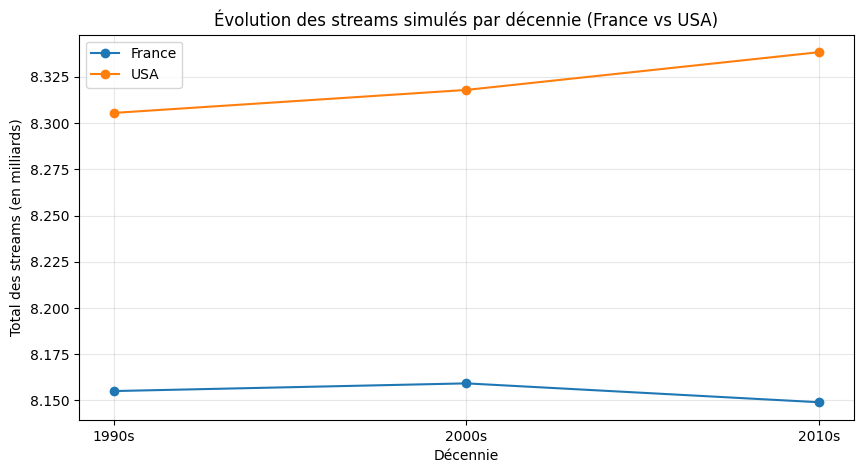

In [51]:
# --- Chargement des données ---
import pandas as pd
import matplotlib.pyplot as plt

# Lecture des CSV depuis ton dossier data
df_fr = pd.read_csv(DATA_DIR / "top100_decade_FR_all.csv")
df_us = pd.read_csv(DATA_DIR / "top100_decade_USA_all.csv")

# --- Vérification rapide ---
print("France :", df_fr.shape, "| USA :", df_us.shape)
display(df_fr.tail(20))
display(df_us.tail(20))

# --- Agrégation par décennie ---
streams_fr = df_fr.groupby("decade")["streams"].sum().reset_index()
streams_us = df_us.groupby("decade")["streams"].sum().reset_index()

# --- Visualisation comparative ---
plt.figure(figsize=(10,5))
plt.plot(streams_fr["decade"], streams_fr["streams"]/1e9, marker="o", label="France")
plt.plot(streams_us["decade"], streams_us["streams"]/1e9, marker="o", label="USA")
plt.title("Évolution des streams simulés par décennie (France vs USA)")
plt.xlabel("Décennie")
plt.ylabel("Total des streams (en milliards)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


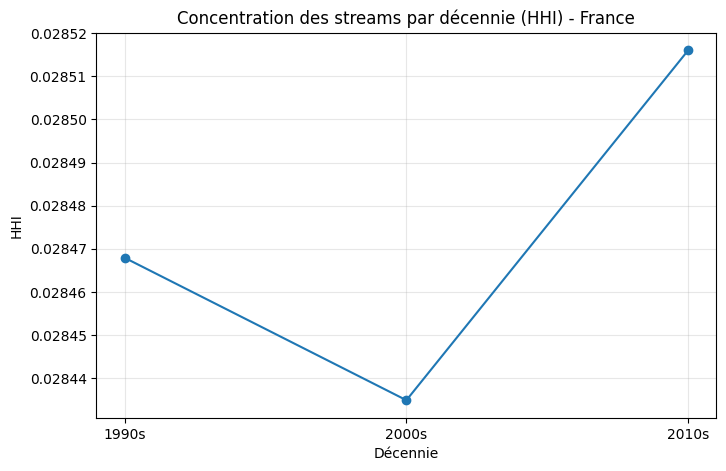

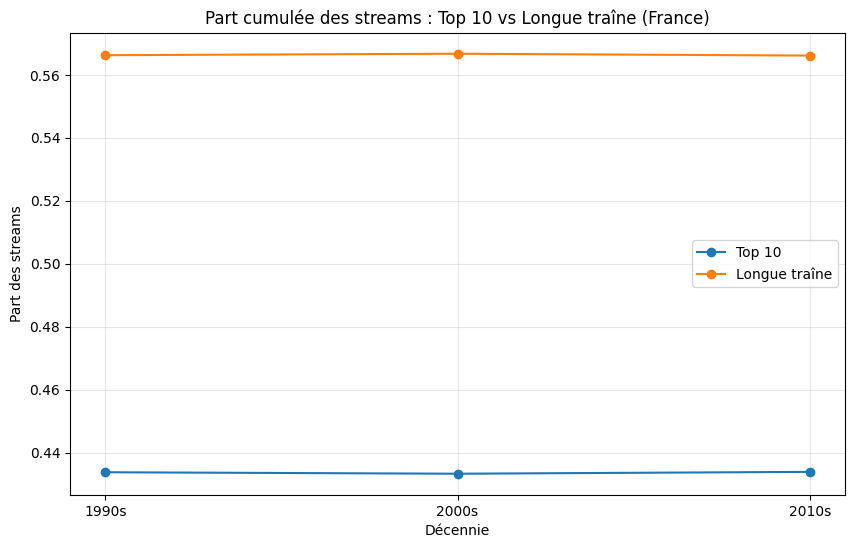

In [52]:
# --- Chargement des données ---
df_fr = pd.read_csv(DATA_DIR / "top100_decade_FR_all.csv")
df_us = pd.read_csv(DATA_DIR / "top100_decade_USA_all.csv")

# Choix du pays à analyser (ici France)
df = df_fr.copy()

# --- 1. Calcul HHI par décennie ---
def calculate_hhi(df):
    hhi_list = []
    for decade, group in df.groupby('decade'):
        shares = group['streams'] / group['streams'].sum()  # part de chaque track
        hhi = (shares**2).sum()
        hhi_list.append({'decade': decade, 'HHI': hhi})
    return pd.DataFrame(hhi_list)

hhi_df = calculate_hhi(df)

plt.figure(figsize=(8,5))
plt.plot(hhi_df['decade'], hhi_df['HHI'], marker='o')
plt.title("Concentration des streams par décennie (HHI) - France")
plt.xlabel("Décennie")
plt.ylabel("HHI")
plt.grid(alpha=0.3)
plt.show()

# --- 2. Part cumulée du top 10 vs longue traîne ---
cumulative_shares = []
for decade, group in df.groupby('decade'):
    group_sorted = group.sort_values('rank')  # du rang 1 au rang 100
    total_streams = group_sorted['streams'].sum()
    top10_share = group_sorted.head(10)['streams'].sum() / total_streams
    long_tail_share = group_sorted.iloc[10:]['streams'].sum() / total_streams
    cumulative_shares.append({'decade': decade, 'Top 10': top10_share, 'Longue traîne': long_tail_share})

cum_df = pd.DataFrame(cumulative_shares)

# --- 3. Visualisation top 10 vs longue traîne ---
plt.figure(figsize=(10,6))
plt.plot(cum_df['decade'], cum_df['Top 10'], marker='o', label='Top 10')
plt.plot(cum_df['decade'], cum_df['Longue traîne'], marker='o', label='Longue traîne')
plt.title("Part cumulée des streams : Top 10 vs Longue traîne (France)")
plt.xlabel("Décennie")
plt.ylabel("Part des streams")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

- Les streams explosent après 2010, signe de l’impact du streaming.

- La longue traîne croît, montrant que les auditeurs explorent plus d’artistes qu’avant.

- Le Top 10 reste dominant, mais sa part relative diminue : le succès se répartit sur davantage de titres.

- Les marchés (France vs USA) présentent des niveaux de concentration différents, reflétant des habitudes d’écoute distinctes.

Takeaway : le modèle actuel favorisant quelques gros artistes est moins représentatif de la diversité réelle des écoutes et pourrait montrer ses limites dans le futur.